In [521]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from sympy.vector import CoordSys3D, AxisOrienter, express, BodyOrienter

# Inosotropic elastic constants

## Links and references

3D rotation:
 * [Rotation formalisms in three dimensions](https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions)
 * [Euler–Rodrigues formula](https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula) and [Rodrigues' rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)
 * [stackoverflow: Rotation of 3D vector?](https://stackoverflow.com/questions/6802577/rotation-of-3d-vector)
 * [python/transforms3d.euler](http://matthew-brett.github.io/transforms3d/reference/transforms3d.euler.html)
 * [Wolfram EulerAngles](http://mathworld.wolfram.com/EulerAngles.html)
 * http://www.iue.tuwien.ac.at/phd/coppeta/DISSse8.html

Elastic tensor & Stiffness:
* http://www.continuummechanics.org/coordxforms.html
* http://homes.civil.aau.dk/lda/Continuum/material.pdf
* https://scicomp.stackexchange.com/a/8102/15117
* see page 78 F. Bower  mech, or [Basis change formulas for anisotropic elastic constants](http://solidmechanics.org/Text/Chapter3_2/Chapter3_2.php#Sect3_2_11)
* Example of 3D graph:
DOI 10.1186/s40759-017-0021-5 : Modeling the copper microstructure and
elastic anisotropy and studying its imp

3D graph and spherical plot:
 * [Evenly distributing points on a sphere](http://extremelearning.com.au/evenly-distributing-points-on-a-sphere/)

## Tensor rotation
[docs.sympy modules/vector/coordsys](https://docs.sympy.org/latest/modules/vector/coordsys.html#orienting-new-systems)

In [525]:
# Rotation angles about z, and x' respectivly
phi, psi = sp.symbols('phi psi')

# The reference frame
A = CoordSys3D('A')

# The rotated frame
#   using "intrinsic" axis of rotation (i.e. body)
B = A.orient_new_body('B', phi, psi, 0, '321')

# Omega = B.rotation_matrix(A)
Omega = A.rotation_matrix(B)  # use the inverse, for K^-1
Omega

Matrix([
[cos(phi)*cos(psi), -sin(phi), sin(psi)*cos(phi)],
[sin(phi)*cos(psi),  cos(phi), sin(phi)*sin(psi)],
[        -sin(psi),         0,          cos(psi)]])

In [523]:
## Genereic Direction cosine matrix
#B = CoordSys3D('B')
#Omega = sp.Matrix(3, 3, lambda i,j: A.base_vectors()[i] & B.base_vectors()[j])#
#Omega

In [524]:
# Basis change matrix is Voigt notation:
K1 = sp.Matrix(3, 3, lambda i,j: Omega[i, j]**2)
K2 = sp.Matrix(3, 3, lambda i,j: Omega[i, (j+1)%3] * Omega[i, (j+2)%3])
K3 = sp.Matrix(3, 3, lambda i,j: Omega[(i+1)%3, j] * Omega[(i+2)%3, j])
K4 = sp.Matrix(3, 3, lambda i,j: Omega[(i+1)%3, (j+1)%3] * Omega[(i+2)%3, (j+2)%3] +\
                                 Omega[(i+1)%3, (j+2)%3] * Omega[(i+2)%3, (j+1)%3])

K = sp.BlockMatrix([[K1, 2*K2], [K3, K4]])
K = K.as_explicit()
K

Matrix([
[      cos(phi)**2*cos(psi)**2,        sin(phi)**2,       sin(psi)**2*cos(phi)**2,                -2*sin(phi)*sin(psi)*cos(phi),              2*sin(psi)*cos(phi)**2*cos(psi),                -2*sin(phi)*cos(phi)*cos(psi)],
[      sin(phi)**2*cos(psi)**2,        cos(phi)**2,       sin(phi)**2*sin(psi)**2,                 2*sin(phi)*sin(psi)*cos(phi),              2*sin(phi)**2*sin(psi)*cos(psi),                 2*sin(phi)*cos(phi)*cos(psi)],
[                  sin(psi)**2,                  0,                   cos(psi)**2,                                            0,                         -2*sin(psi)*cos(psi),                                            0],
[  -sin(phi)*sin(psi)*cos(psi),                  0,    sin(phi)*sin(psi)*cos(psi),                            cos(phi)*cos(psi), -sin(phi)*sin(psi)**2 + sin(phi)*cos(psi)**2,                           -sin(psi)*cos(phi)],
[  -sin(psi)*cos(phi)*cos(psi),                  0,    sin(psi)*cos(phi)*cos(psi),                     

## Linear stress-strain relations
- for cubic material

[Linear elastic stress-strain relations for cubic materials](http://solidmechanics.org/Text/Chapter3_2/Chapter3_2.php#Sect3_2_16)

In [445]:
# Stiffness tensor for cubic cristal
c11, c44, c12 = sp.symbols('c11, c44, c12')
C_cubic_cristal = sp.diag(*[c11, c11, c11, c44, c44, c44])

C_cubic_cristal[0, 1] = C_cubic_cristal[1, 0] = c12
C_cubic_cristal[0, 2] = C_cubic_cristal[2, 0] = c12
C_cubic_cristal[1, 2] = C_cubic_cristal[2, 1] = c12
C_cubic_cristal

Matrix([
[c11, c12, c12,   0,   0,   0],
[c12, c11, c12,   0,   0,   0],
[c12, c12, c11,   0,   0,   0],
[  0,   0,   0, c44,   0,   0],
[  0,   0,   0,   0, c44,   0],
[  0,   0,   0,   0,   0, c44]])

In [448]:
C_cristal = C_cubic_cristal

# Get symbols list
c_ij = sorted([c.name for c in C_cristal.free_symbols])

# Compliance tensor
S_cristal = C_cristal.inv()

# Apply the transformation
S_rotated = K.T * S_cristal * K

In [529]:
# e = sp.simplify(e)
# Find Max ?
# see https://stackoverflow.com/questions/48214475/sympy-unable-to-solve-a-system-of-trigonometric-equations

In [530]:
E_Young_100 = sp.simplify( 1/S_rotated[0, 0].subs([(phi, 0), (psi, 0)]) )
E_Young_111 = sp.simplify( 1/S_rotated[0, 0].subs([(phi, sp.pi/4), (psi, sp.acos(2/sp.sqrt(6)))]) )

In [531]:
E_Young_111

3*c44*(c11 + 2*c12)/(c11 + 2*c12 + c44)

In [532]:
sp.simplify( E_Young_111/E_Young_100 )

3*c44*(c11 + c12)/(c11**2 + c11*c12 + c11*c44 - 2*c12**2 - c12*c44)

# Graphs en projection stereographique

In [533]:
# Go to numpy
calc_s11 = sp.lambdify(('phi', 'psi', c_ij), S_rotated[0, 0])

In [451]:
import csv

In [535]:
# Load data of elastic constants
def parse_str_to_float(value):
    return float(value.replace(',', '.').replace('\u202f', ''))

filename = 'elastic_consts_materials.csv'
materials_props = {}
with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
        
    next(reader) # skip the first line
    names = next(reader)
    for row in reader:
        mat_name = f'{row[0]}({row[1]})' # Symbol + structure
        materials_props[mat_name] = {cij:parse_str_to_float(value) for cij, value
                                     in zip(['c11','c44','c12'], row[2:])}
        
print('nbr materials:', len(materials_props))

nbr materials: 30


In [473]:
def projection(phi_M, psi_M):
    psi_equal_area_proj = 2*np.sin(psi_M / 2)
    psi_stereo_projection = 2*np.tan(psi_M / 2)
    x, y = psi_equal_area_proj*np.cos(phi_M), psi_equal_area_proj*np.sin(phi_M)
    
    return x, y

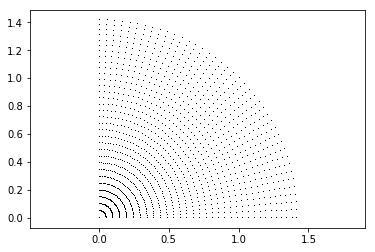

In [474]:
# Mesh the sphere
phi_span = np.linspace(0, np.pi/2, 41)
psi_span = np.linspace(0, np.pi/2, 33)

#phi, psi = mesh_circle(1804, r_max=np.pi/2)

phi_M, psi_M = np.meshgrid(phi_span, psi_span)

x, y = projection(phi_M, psi_M)

plt.plot(x, y, 'k,')
plt.axis('equal');

In [505]:
cristal_dir = {'111':(np.pi/4, np.arccos(1/np.sqrt(3))), #phi, psi
               '001':(0, 0), 
               '100':(0, np.pi/2),
               '101':(0, np.pi/4),
               '110':(np.pi/4, np.pi/2),
               '010':(np.pi/2, np.pi/2)}

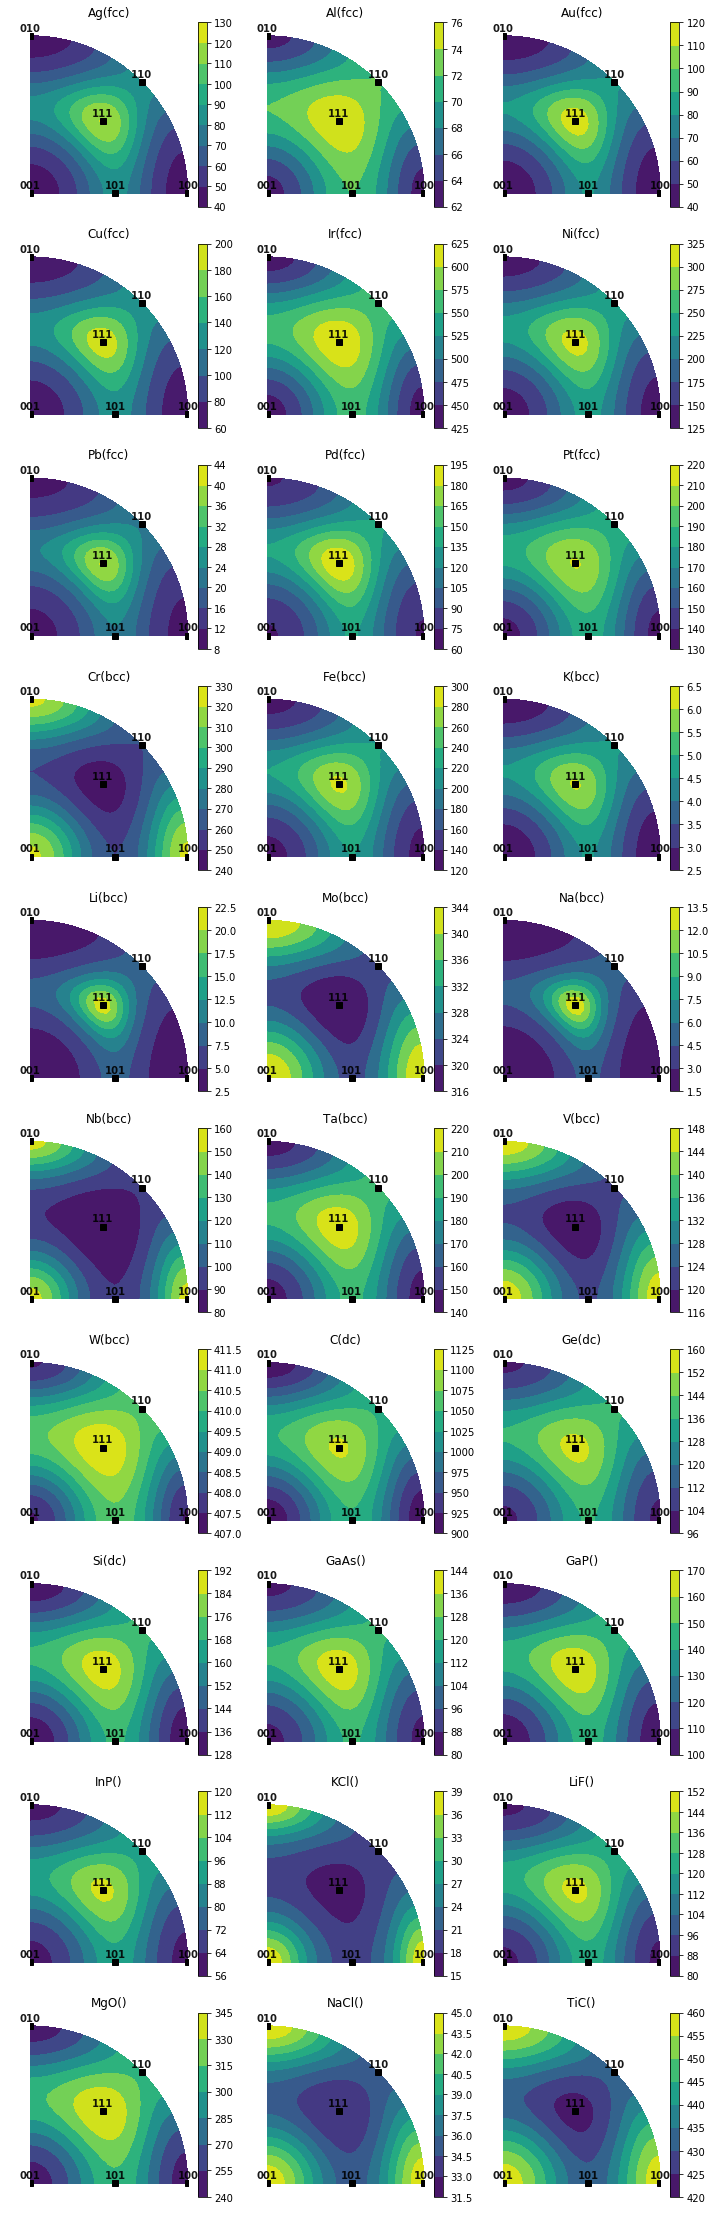

In [508]:
fig = plt.figure(figsize = (12, 40))
#phi_M, psi_M = np.meshgrid(phi_span, psi_span)

for k, (name, props) in enumerate(materials_props.items()):
    
    material_properties = [props[ij] for ij in c_ij]
    E_Young =  1/calc_s11(phi_M, np.pi/2 - psi_M, material_properties)
    
    plt.subplot(10, 3, k+1)
    plt.contourf(x, y, E_Young)
    plt.axis('equal')
    plt.colorbar()
    plt.title(name)
    plt.axis('off')
       
    # Annotation
    for hkl, phi_psi in cristal_dir.items():
        xy = projection(*phi_psi)
        plt.plot(*xy, 'ks')
        plt.annotate(hkl, xy, 
                   textcoords='offset pixels', xytext=(0, 5),
                   rotation=0, alpha=0.9, color='black', family='sans-serif',
                   horizontalalignment='center', va='baseline', weight='bold')


# Graphs min-->max 

In [536]:
E_Young_111

3*c44*(c11 + 2*c12)/(c11 + 2*c12 + c44)

In [538]:
E_Young_100

(c11**2 + c11*c12 - 2*c12**2)/(c11 + c12)

In [541]:
# Go to numpy
calc_E_Young_111 = sp.lambdify(c_ij, E_Young_111)
calc_E_Young_100 = sp.lambdify(c_ij, E_Young_100)

In [588]:
color_code = {'bcc':'olivedrab', 'fcc':'steelblue', 'dc':'orangered'}
def get_color(name):
    for key, color in color_code.items():
        if key in name:
            return color
    else:
        return 'black'

In [591]:
from matplotlib.lines import Line2D

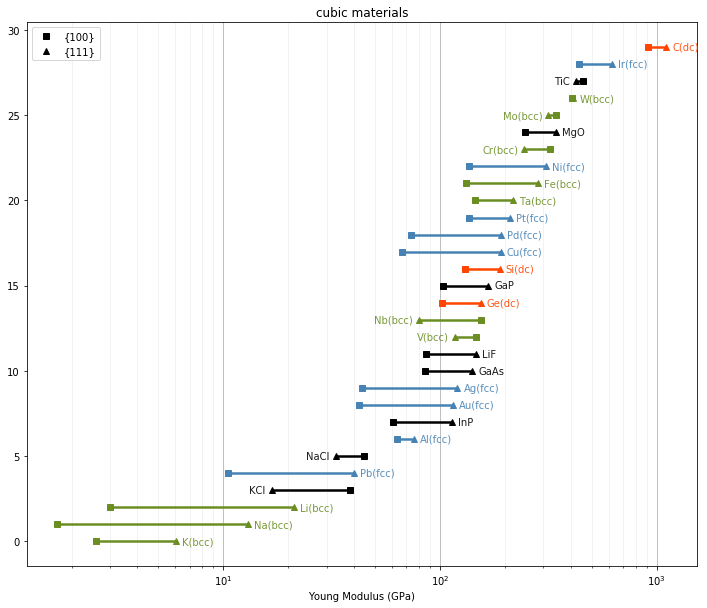

In [597]:
young_111_110 = []
for k, (name, props) in enumerate(materials_props.items()):
    
    material_properties = [props[ij] for ij in c_ij]
    young111 =  calc_E_Young_111(*material_properties)
    young100 =  calc_E_Young_100(*material_properties)
    
    young_111_110.append((name, young111, young100))
    

young_111_110 = sorted(young_111_110, key=lambda x:max(x[1], x[2]))

fig = plt.figure(figsize = (12, 10))
for k, (name, young111, young100) in enumerate(young_111_110):
    name = name.replace('()', '')
    color = get_color(name)
    plt.semilogx([young100, young111], [k, k], '-', linewidth=2.5, color=color)
    plt.semilogx([young111], [k], '^', color=color)
    plt.semilogx([young100], [k], 's', color=color)
    
    reverse = young100 > young111
    plt.annotate(name, (young111, k), 
               textcoords='offset pixels',
               xytext= (-6, 0) if reverse else  (6, 0),
               rotation=0, alpha=0.9, color=color, family='sans-serif',
               horizontalalignment='right' if reverse else 'left',
               va='center', weight='normal')
    
plt.xlabel("Young Modulus (GPa)");
plt.title('cubic materials');
plt.grid(True, axis='x', which='major');
plt.grid(True, axis='x', which='minor', alpha=0.2);

legend_elements = [Line2D([0], [0], marker='s', color='k', label='{100}', linewidth=0),
                   Line2D([0], [0], marker='^', color='k', label='{111}', linewidth=0)]
plt.legend(handles=legend_elements);

# Next

In [526]:
# Stiffness tensor
# for linear elastic Transversely Isotropic Material
c_ij_str = 'c11 c33 c44 c12 c13'
coeffs = sp.symbols(c_ij_str)
c66 = (coeffs[0] - coeffs[3])/2
C_cristal = sp.diag(*[coeffs[0], coeffs[0], coeffs[1], coeffs[2], coeffs[2], c66])

C_cristal[0, 1] = C_cristal[1, 0] = coeffs[3]
C_cristal[0, 2] = C_cristal[2, 0] = coeffs[4]
C_cristal[1, 2] = C_cristal[2, 1] = coeffs[4]

C_cristal

Matrix([
[c11, c12, c13,   0,   0,             0],
[c12, c11, c13,   0,   0,             0],
[c13, c13, c33,   0,   0,             0],
[  0,   0,   0, c44,   0,             0],
[  0,   0,   0,   0, c44,             0],
[  0,   0,   0,   0,   0, c11/2 - c12/2]])

## 3d graph

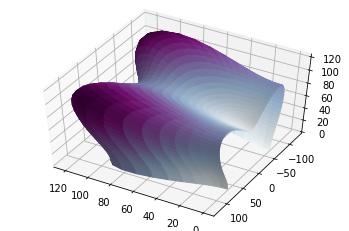

In [91]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = E_Young * np.cos(phi_M) * np.cos(psi_M)
Y = E_Young * np.sin(phi_M) * np.cos(psi_M)
Z = E_Young * np.sin(psi_M)

E_Young_normed = (E_Young - E_Young.min())/(E_Young.max() - E_Young.min())
# Plot the surface
colors = plt.cm.BuPu(E_Young_normed)
ax.plot_surface(X, Y, Z, facecolors=colors)
ax.view_init(elev=50., azim=120)
plt.show()

In [527]:
# import ipyvolume as ipv